# Particle Swarm Optimization (PSO)

* Algoritmo evolucionário
* Reproduzir comportamento de espécies

<img src = "images/birds.png" width = 800>

## The Cornfield Vector
* Simular geograficamente o comportamento das espécies
* Lembrança da melhor posição individual
* Lembrança da melhor posição global

<img src="images/cornfieldvector.png" width = 500>

In [1]:
import numpy as np

### Funções gerais

#### Minimizar x**2 + y**2

<img src="images/function.png" width=300>

In [2]:
class Utils:
    
    # Calcula a distância euclidiana
    @staticmethod
    def function(position):
        position = np.array(position)
        result = sum(position**2)
        return result

### Classe de partículas

<img src = "images/particle.png" width = 400>

In [3]:
class Particle:

    # Construtor: Inicializa as dimensões, limites, posição, velocidade, e as melhores posições
    def __init__(self, num_dimensions, bounds):
        self.num_dimensions = num_dimensions # Número de dimensões da partícula
        self.bounds = bounds # Limites de cada dimensão
        self.position = [] # Lista para armazenar a posição atual
        self.velocity = [] # Lista para armazenar a velocidade atual
        
        self.pbest = [] # Melhor posição pessoal
        self.pbest_score = np.inf # Melhor pontuação pessoal inicializada como infinito
        self.score = np.inf # Pontuação atual inicializada como infinito
        
        # Para cada dimensão definir valores aleatórios entre os limites
        for i in range(self.num_dimensions):
            lower_bound = self.bounds[i][0] # Limite inferior
            upper_bound = self.bounds[i][1] # Limite superior

            self.position.append(np.random.uniform(lower_bound, upper_bound)) # posição aleatória
            self.velocity.append(np.random.uniform(lower_bound, upper_bound)) # velocidade aleatória


    # Representação da partícula com sua posição e velocidade 
    def __repr__(self):
        return f"\nPosition {self.position}\nVelocity {self.velocity}"


    '''
        Avaliação da função e atualização do pbest
        Calcula a pontuação atual e verifica se é a melhor até agora
    '''
    def evaluate(self):
        self.score = Utils.function(self.position)

        # Atualiza a melhor posição pessoal se a pontuação atual for melhor
        if self.score < self.pbest_score:
            self.pbest = self.position # Atualiza a melhor posição 
            self.pbest_score = self.score # Atualiza a melhor pontuação pessoal
            

    '''
        Gerando nova velocidade baseado na melhor posição (local ou global)
        Todas as operações são feitas simultaneamente para todas as dimensões
        Args:
            - best: posição do melhor (pbest ou gbest)
    '''
    def calculate_velocity(self, best):
        # Calculando diferença entre a posição atual e a melhor posição
        delta = np.array(best) - np.array(self.position)
        
        # Sorteando magnitude aleatória
        magnitude = np.random.uniform(0, 0.51, size = self.num_dimensions)
        magnitude = np.round(magnitude, 2)
        
        # Multiplica a magnitude pela diferença (delta) para calcular a nova velocidade
        return delta*magnitude
    

    '''
        Atualizar a nova velocidade
        Calcula a velocidade cognitiva (pbest) e a velocidade social (gbest) e atualiza a própria velocidade
        baseado em uma taxa para cada velocidade
    '''
    def update_velocity(self, gbest_pos, velocity_rate):
        # Calcula a velocidade cognitiva baseada na melhor posição pessoal
        cognitive_velocity = self.calculate_velocity(self.pbest)

        # Calcula a velocidade social baseada na melhor posição global
        social_velocity = self.calculate_velocity(gbest_pos)
        
        # Atualiza a velocidade da partícula com base nas taxas de velocidade
        self.velocity = (np.array(self.velocity)*velocity_rate[0]
                        + cognitive_velocity * velocity_rate[1]
                        + social_velocity * velocity_rate[2])
        

    # Atualizando a posição e verificando os limites
    def update_position(self):
        self.position = list(np.array(self.position) + np.array(self.velocity))
                

### Classe do enxame

In [4]:
class Swarm:

    # Construtor: Inicializa o enxame com partículas e a melhor posição global (gbest)
    def __init__(self, particles):
        self.particles = particles # Lista de partículas no enxame
        self.gbest = [] # Melhor posição global inicial
        self.gbest_score = np.inf # Melhor pontuação global inicializada como infinito
        

    # Percorre todas as partículas para avaliá-las
    def swarm_evaluate(self):
        for p in self.particles:
            p.evaluate()


    '''
        Atualiza as velocidades de todas as partículas.
        Chama a função de atualização de velocidade de cada partícula
        
        Args:
            VELOCITY_RATE: Taxas para cada componente da velocidade
    '''        
    def swarm_update_velocities(self, VELOCITY_RATE):
        for p in self.particles:
            p.update_velocity(self.gbest, VELOCITY_RATE) # Atualiza a velocidade com base na melhor posição global

    # Atualiza as posições de todas as partículas
    def swarm_update_positions(self):
        for p in self.particles:
            p.update_position()


    '''
        Atualiza a melhor posição global (gbest) baseada no pbest de cada partícula
        Verifica se o pbest de uma partícula é melhor que o gbest atual
    '''        
    def swarm_update_gbest(self):
        for p in self.particles:
            # Se a pontuação da melhor posição pessoal for melhor que a global, atualiza
            if p.pbest_score < self.gbest_score:
                self.gbest_score = p.pbest_score # Atualiza a melhor pontuação global
                self.gbest = p.pbest # Atualiza a melhor posição global


    # Calcula a pontuação média do enxame            
    def swarm_mean_score(self):
        # Lendo a pontuação de cada partícula e colocando em uma lista
        scores = [p.score for p in self.particles]
        return (sum(scores) / len(scores))

### Principal

In [5]:
from plot_utils2 import PlotUtils

NUM_ITERATIONS = 20
NUM_PARTICLES = 10
NUM_DIMENSIONS = 2
BOUNDS = [(-10, 10), (-10, 10)] # Limites para as posições das partículas
VELOCITY_RATE = [0.5, 0.25, 0.25] # Taxas para calcular a nova velocidade

if __name__ == "__main__":
    PlotUtils.start_plot()
    gbest_historic = []
    score_historic = []
    particles = []

    
    for i in range(NUM_PARTICLES):
        particles.append(Particle(NUM_DIMENSIONS, BOUNDS))
    swarm = Swarm(particles)

    print("Iniciando as iterações ...")
    i = 0
    while i < NUM_ITERATIONS:
        print(f"Iteração {i}")
        
        swarm.swarm_evaluate()
        swarm.swarm_update_gbest()
        swarm.swarm_update_velocities(VELOCITY_RATE)
        swarm.swarm_update_positions()
        
        gbest_historic.append(swarm.gbest_score)
        score_historic.append(swarm.swarm_mean_score())

        for p in swarm.particles:
            PlotUtils.plot_particle(p)
        PlotUtils.plot_iteration(i)
        
        i += 1

    PlotUtils.save()

Iniciando as iterações ...
Iteração 0
Iteração 1
Iteração 2
Iteração 3
Iteração 4
Iteração 5
Iteração 6
Iteração 7
Iteração 8
Iteração 9
Iteração 10
Iteração 11
Iteração 12
Iteração 13
Iteração 14
Iteração 15
Iteração 16
Iteração 17
Iteração 18
Iteração 19


Melhor posição: [-0.6170460090507761, -0.9769449597088226]
Melhor pontuação: 1.3351672315859635


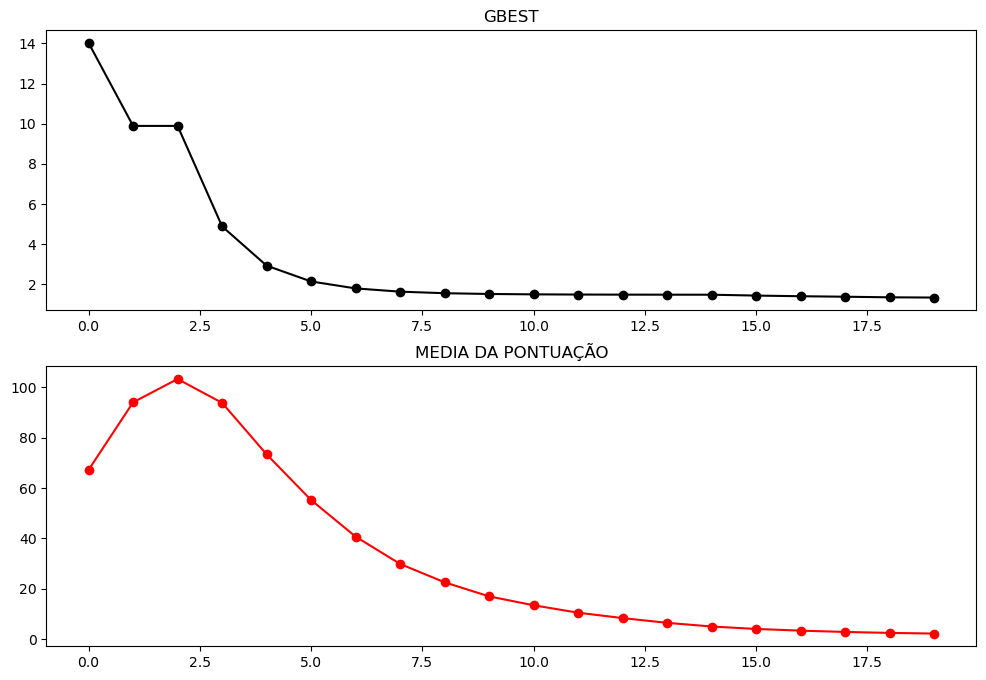

In [6]:
import matplotlib.pyplot as plt

print(f"Melhor posição: {swarm.gbest}")
print(f"Melhor pontuação: {swarm.gbest_score}")

plt.figure(figsize = (12,8))

plt.subplot(2, 1, 1)
plt.title("GBEST")
plt.plot(gbest_historic, marker = 'o', color = 'black')

plt.subplot(2, 1, 2)
plt.title("MEDIA DA PONTUAÇÃO")
plt.plot(score_historic, marker = 'o', color = 'red')

plt.show()

# MAXIMIZAÇÃO

### Classe de partículas

<img src = "images/particle.png" width = 400>

In [7]:
class Particle:

    # Construtor: Inicializa as dimensões, limites, posição, velocidade, e as melhores posições
    def __init__(self, num_dimensions, bounds):
        self.num_dimensions = num_dimensions # Número de dimensões da partícula
        self.bounds = bounds # Limites de cada dimensão
        self.position = [] # Lista para armazenar a posição atual
        self.velocity = [] # Lista para armazenar a velocidade atual
        
        self.pbest = [] # Melhor posição pessoal
        self.pbest_score = -np.inf # Melhor pontuação pessoal inicializada como negativo infinito
        self.score = -np.inf # Pontuação atual inicializada como negativo infinito
        
        # Para cada dimensão definir valores aleatórios entre os limites
        for i in range(self.num_dimensions):
            lower_bound = self.bounds[i][0] # Limite inferior
            upper_bound = self.bounds[i][1] # Limite superior

            self.position.append(np.random.uniform(lower_bound, upper_bound)) # posição aleatória
            self.velocity.append(np.random.uniform(lower_bound, upper_bound)) # velocidade aleatória


    # Representação da partícula com sua posição e velocidade 
    def __repr__(self):
        return f"\nPosition {self.position}\nVelocity {self.velocity}"


    '''
        Avaliação da função e atualização do pbest
        Calcula a pontuação atual e verifica se é a melhor até agora
    '''
    def evaluate(self):
        self.score = Utils.function(self.position)

        # Atualiza a melhor posição pessoal se a pontuação atual for melhor
        if self.score > self.pbest_score:  # Note a mudança aqui
            self.pbest = self.position # Atualiza a melhor posição 
            self.pbest_score = self.score # Atualiza a melhor pontuação pessoal
            


    '''
        Gerando nova velocidade baseado na melhor posição (local ou global)
        Todas as operações são feitas simultaneamente para todas as dimensões
        Args:
            - best: posição do melhor (pbest ou gbest)
    '''
    def calculate_velocity(self, best):
        # Calculando diferença entre a posição atual e a melhor posição
        delta = np.array(best) - np.array(self.position)
        
        # Sorteando magnitude aleatória
        magnitude = np.random.uniform(0, 0.51, size=self.num_dimensions)
        magnitude = np.round(magnitude, 2)
        
        # Multiplica a magnitude pela diferença (delta) para calcular a nova velocidade
        return delta * magnitude
     

    '''
        Atualizar a nova velocidade
        Calcula a velocidade cognitiva (pbest) e a velocidade social (gbest) e atualiza a própria velocidade
        baseado em uma taxa para cada velocidade
    '''
    def update_velocity(self, gbest_pos, velocity_rate):
        # Calcula a velocidade cognitiva baseada na melhor posição pessoal
        cognitive_velocity = self.calculate_velocity(self.pbest)

        # Calcula a velocidade social baseada na melhor posição global
        social_velocity = self.calculate_velocity(gbest_pos)
        
        # Atualiza a velocidade da partícula com base nas taxas de velocidade
        self.velocity = (np.array(self.velocity) * velocity_rate[0]
                        + cognitive_velocity * velocity_rate[1]
                        + social_velocity * velocity_rate[2])
        

    # Atualizando a posição e verificando os limites
    def update_position(self):
        self.position = list(np.array(self.position) + np.array(self.velocity))


### Classe do enxame

In [8]:
class Swarm:

    # Construtor: Inicializa o enxame com partículas e a melhor posição global (gbest)
    def __init__(self, particles):
        self.particles = particles # Lista de partículas no enxame
        self.gbest = [] # Melhor posição global inicial
        self.gbest_score = -np.inf # Melhor pontuação global inicializada como negativo infinito
        

    # Percorre todas as partículas para avaliá-las
    def swarm_evaluate(self):
        for p in self.particles:
            p.evaluate()


    '''
        Atualiza as velocidades de todas as partículas.
        Chama a função de atualização de velocidade de cada partícula
        
        Args:
            VELOCITY_RATE: Taxas para cada componente da velocidade
    '''        
    def swarm_update_velocities(self, VELOCITY_RATE):
        for p in self.particles:
            p.update_velocity(self.gbest, VELOCITY_RATE) # Atualiza a velocidade com base na melhor posição global

    # Atualiza as posições de todas as partículas
    def swarm_update_positions(self):
        for p in self.particles:
            p.update_position()


    '''
        Atualiza a melhor posição global (gbest) baseada no pbest de cada partícula
        Verifica se o pbest de uma partícula é melhor que o gbest atual
    '''        
    def swarm_update_gbest(self):
        for p in self.particles:
            # Se a pontuação da melhor posição pessoal for melhor que a global, atualiza
            if p.pbest_score > self.gbest_score:  # Note a mudança aqui
                self.gbest_score = p.pbest_score # Atualiza a melhor pontuação global
                self.gbest = p.pbest # Atualiza a melhor posição global


    # Calcula a pontuação média do enxame            
    def swarm_mean_score(self):
        # Lendo a pontuação de cada partícula e colocando em uma lista
        scores = [p.score for p in self.particles]
        return (sum(scores) / len(scores))

### Principal

In [9]:
from plot_utils import PlotUtils

NUM_ITERATIONS = 20
NUM_PARTICLES = 10
NUM_DIMENSIONS = 2
BOUNDS = [(-1500, 1500), (-1500, 1500)] # Limites para as posições das partículas
VELOCITY_RATE = [0.5, 0.25, 0.25] # Taxas para calcular a nova velocidade

if __name__ == "__main__":
    PlotUtils.start_plot()
    gbest_historic = []
    score_historic = []
    particles = []

    
    for i in range(NUM_PARTICLES):
        particles.append(Particle(NUM_DIMENSIONS, BOUNDS))
    swarm = Swarm(particles)

    print("Iniciando as iterações ...")
    i = 0
    while i < NUM_ITERATIONS:
        print(f"Iteração {i}")
        
        swarm.swarm_evaluate()
        swarm.swarm_update_gbest()
        swarm.swarm_update_velocities(VELOCITY_RATE)
        swarm.swarm_update_positions()
        
        gbest_historic.append(swarm.gbest_score)
        score_historic.append(swarm.swarm_mean_score())

        for p in swarm.particles:
            PlotUtils.plot_particle(p)
        PlotUtils.plot_iteration(i)
        
        i += 1

    PlotUtils.save()


Iniciando as iterações ...
Iteração 0
Iteração 1
Iteração 2
Iteração 3
Iteração 4
Iteração 5
Iteração 6
Iteração 7
Iteração 8
Iteração 9
Iteração 10
Iteração 11
Iteração 12
Iteração 13
Iteração 14
Iteração 15
Iteração 16
Iteração 17
Iteração 18
Iteração 19


Melhor posição: [2462.4314065057533, -1396.9757642876275]
Melhor pontuação: 8015109.717752904


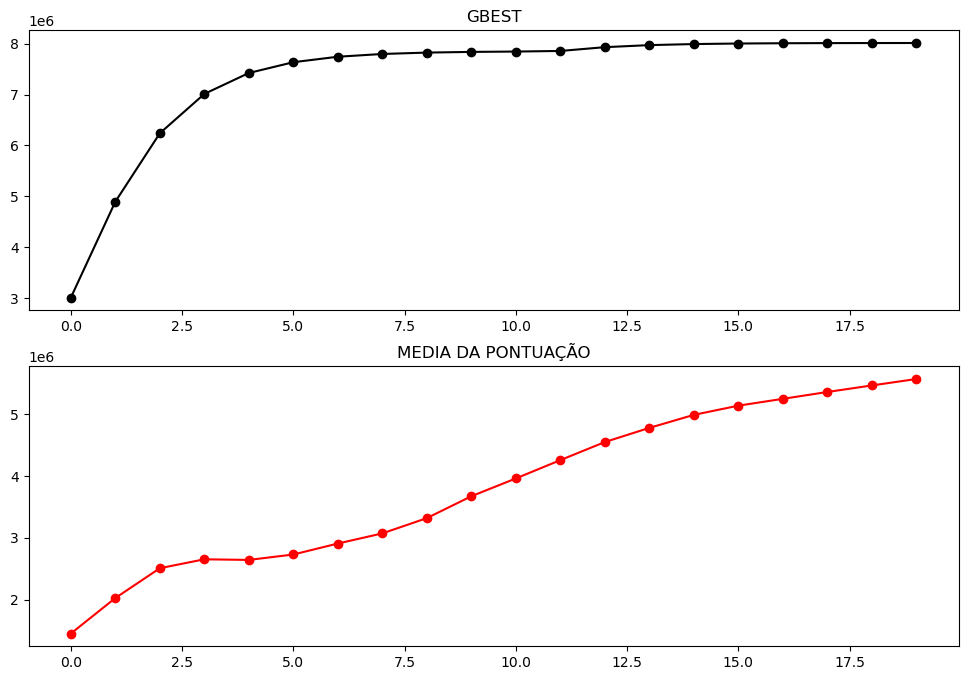

In [10]:
import matplotlib.pyplot as plt

print(f"Melhor posição: {swarm.gbest}")
print(f"Melhor pontuação: {swarm.gbest_score}")

plt.figure(figsize = (12,8))

plt.subplot(2, 1, 1)
plt.title("GBEST")
plt.plot(gbest_historic, marker = 'o', color = 'black')

plt.subplot(2, 1, 2)
plt.title("MEDIA DA PONTUAÇÃO")
plt.plot(score_historic, marker = 'o', color = 'red')

plt.show()